In [1]:
import numpy as np
import multiprocessing as mp
from scipy.stats import norm, normaltest, ttest_1samp
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from jobs import simulate_job
from config_plt import config_plt, get_fig_ax, save_my_fig

In [2]:
mp.set_start_method("spawn", force=True)
T = 100_000
n_reps = 2_000
a_target = 100
n_jobs = 4
args = [(seed, T, a_target) for seed in range(n_reps)]
with mp.Pool(processes=n_jobs) as pool:
    results = list(tqdm(pool.imap_unordered(simulate_job, args, chunksize=1), total=n_reps))

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:56<00:00, 35.19it/s]


In [3]:
psis = np.asarray([r["psi"] for r in results])
psis_naive = np.asarray([r["psi_naive"] for r in results])
tauhats = np.asarray([r["tauhat"] for r in results])
taus = np.asarray([r["tau"] for r in results])
equal_groups = np.asarray([r["equal_group"] for r in results])
t_targets = np.asarray([r["t_target"] for r in results])
us = tauhats - taus
zs = us / np.sqrt(psis / T)
zs_naive = us / np.sqrt(psis_naive / T)

In [4]:
psis_equal = psis[equal_groups]
psis_equal_mean = np.mean(psis_equal)
print(psis_equal_mean)
psis_naive_equal = psis_naive[equal_groups]
psis_naive_equal_mean = np.mean(psis_naive_equal)
print(psis_naive_equal_mean)

psis_unequal = psis[~equal_groups]
psis_unequal_mean = np.mean(psis_unequal)
print(psis_unequal_mean)
psis_naive_unequal = psis_naive[~equal_groups]
psis_naive_unequal_mean = np.mean(psis_naive_unequal)
print(psis_naive_unequal_mean)

159.60597681407742
113.53429460905124
245.36772531392552
168.2001962883695


TtestResult(statistic=np.float64(0.26157237245589054), pvalue=np.float64(0.7936780934778651), df=np.int64(1999))
TtestResult(statistic=np.float64(1.1443793800009807), pvalue=np.float64(0.2526033419556391), df=np.int64(1999))
NormaltestResult(statistic=np.float64(0.6534953580167077), pvalue=np.float64(0.7212657105478547))
./figures/z


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


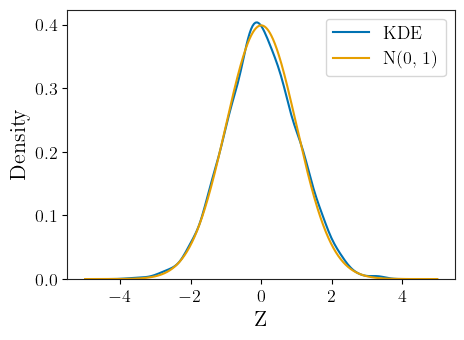

In [5]:
print(ttest_1samp(zs, popmean=0.))
print(ttest_1samp(zs**2, popmean=1.))
print(normaltest(zs))
fig, ax = get_fig_ax()
ax = sns.kdeplot(zs, ax=ax, bw_method=0.2, label="KDE")
zs_vals = np.linspace(-5, 5, 1000)
gaussian_pdf_vals = norm.pdf(zs_vals)
ax.plot(zs_vals, gaussian_pdf_vals, label="N(0, 1)")
ax.set_xlabel("Z")
ax.legend()
save_my_fig(fig, "z")

TtestResult(statistic=np.float64(0.3689647786544415), pvalue=np.float64(0.7121930521825792), df=np.int64(1999))
TtestResult(statistic=np.float64(8.683526454446337), pvalue=np.float64(7.820333257737686e-18), df=np.int64(1999))
NormaltestResult(statistic=np.float64(0.5929341399930219), pvalue=np.float64(0.7434401083463829))
./figures/z-naive


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


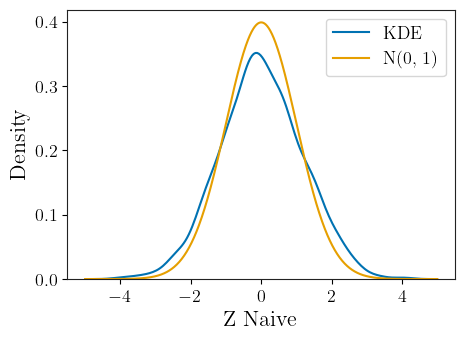

In [6]:
print(ttest_1samp(zs_naive, popmean=0.))
print(ttest_1samp(zs_naive**2, popmean=1.))
print(normaltest(zs_naive))
fig, ax = get_fig_ax()
ax = sns.kdeplot(zs_naive, ax=ax, bw_method=0.2, label="KDE")
ax.plot(zs_vals, gaussian_pdf_vals, label="N(0, 1)")
ax.set_xlabel("Z Naive")
ax.legend()
save_my_fig(fig, "z-naive")

TtestResult(statistic=np.float64(0.6190003718722985), pvalue=np.float64(0.535986646653414), df=np.int64(1999))
NormaltestResult(statistic=np.float64(21.012196370986373), pvalue=np.float64(2.7369037945492822e-05))
./figures/u


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


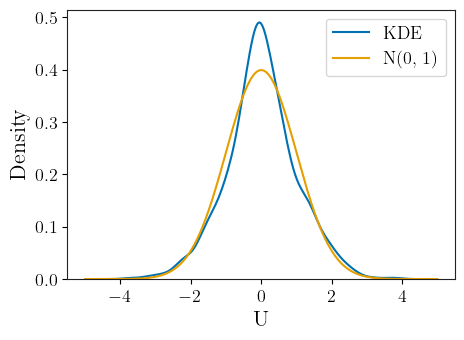

In [7]:
us_std = us / np.std(us)
print(ttest_1samp(us_std, popmean=0.))
# print(ttest_1samp(us_std**2, popmean=1.))
print(normaltest(us_std))
fig, ax = get_fig_ax()
ax = sns.kdeplot(us_std, bw_method=0.2, ax=ax, label="KDE")
ax.plot(zs_vals, gaussian_pdf_vals, label="N(0, 1)")
ax.set_xlabel("U")
ax.legend()
save_my_fig(fig, "u")

(array([ 12.,  87., 228., 436., 517., 389., 231.,  70.,  23.,   7.]),
 array([158. , 167.3, 176.6, 185.9, 195.2, 204.5, 213.8, 223.1, 232.4,
        241.7, 251. ]),
 <BarContainer object of 10 artists>)

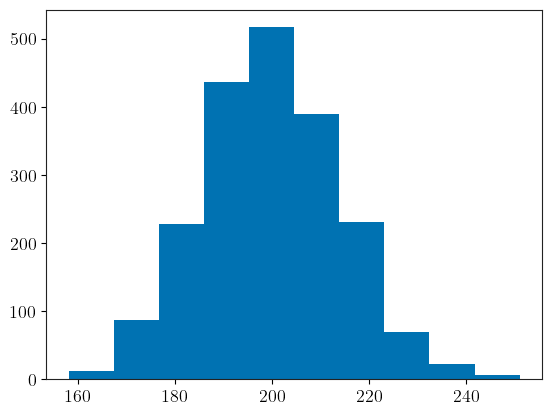

In [8]:
plt.hist(t_targets)

(array([  7.,  33., 116., 295., 690., 507., 242.,  90.,  17.,   3.]),
 array([0.83496742, 0.86915016, 0.9033329 , 0.93751564, 0.97169838,
        1.00588112, 1.04006386, 1.0742466 , 1.10842934, 1.14261208,
        1.17679482]),
 <BarContainer object of 10 artists>)

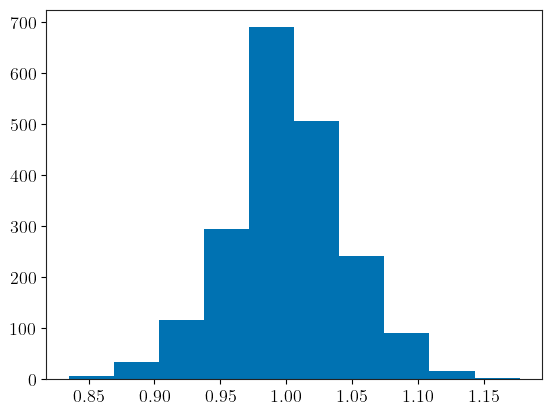

In [9]:
plt.hist(tauhats)

(array([  4.,  13.,  90., 262., 456., 519., 392., 197.,  56.,  11.]),
 array([0.98158689, 0.98503789, 0.9884889 , 0.9919399 , 0.99539091,
        0.99884191, 1.00229292, 1.00574392, 1.00919492, 1.01264593,
        1.01609693]),
 <BarContainer object of 10 artists>)

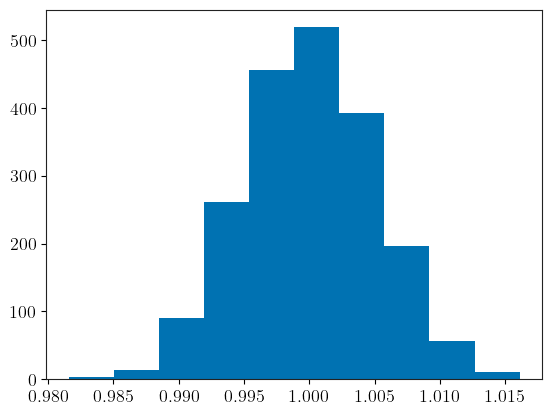

In [10]:
plt.hist(taus)